## Estimating CDF and PDF from Monte Carlo samples
Given a bunch of random numbers from a simulation experiment, one of the first steps is to visualize the CDF and PDF. The ECDF is quite useful for, say, visualizing how similar or different two sets of data are.

In [2]:
# Make up some random data
import numpy as np
x = np.r_[np.random.normal(0, 1, 10000),
          np.random.normal(4, 1, 10000)]

In [4]:
# Roll our own ECDF function

def ecdf(x):
    """Return empirical CDF of x."""

    sx = np.sort(x)
    cdf = (1.0 + np.arange(len(sx)))/len(sx)
    return sx, cdf

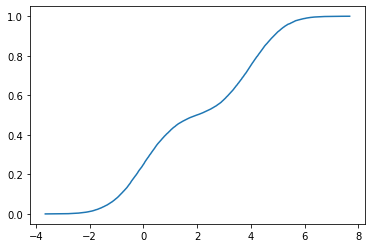

In [5]:
import matplotlib.pyplot as plt

sx, y = ecdf(x)
plt.plot(sx, y)
pass

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


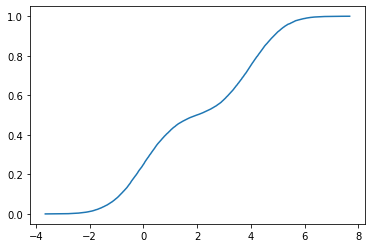

In [6]:
from statsmodels.distributions.empirical_distribution import ECDF

ecdf = ECDF(x)
plt.plot(ecdf.x, ecdf.y)
pass

## Estimating the PDF

The simplest is to plot a normalized histogram as shown above, but we will also look at how to estimate density functions using kernel density estimation (KDE). KDE works by placing a kernel unit on each data point, and summing the kernels to present a smoother estimate than you would get with a (n-d) histogram.

In [7]:
def epanechnikov(u):
    """Epanechnikov kernel."""
    return np.where(np.abs(u) <= np.sqrt(5), 3/(4*np.sqrt(5)) * (1 - u*u/5.0), 0)

def silverman(y):
    """Find bandwidth using heuristic suggested by Silverman
    .9 min(standard deviation, interquartile range/1.34)n−1/5
    """
    n = len(y)
    iqr = np.subtract(*np.percentile(y, [75, 25]))
    h = 0.9*np.min([y.std(ddof=1), iqr/1.34])*n**-0.2
    return h

def kde(x, y, bandwidth=silverman, kernel=epanechnikov):
    """Returns kernel density estimate.
    x are the points for evaluation
    y is the data to be fitted
    bandwidth is a function that returens the smoothing parameter h
    kernel is a function that gives weights to neighboring data
    """
    h = bandwidth(y)
    return np.sum(kernel((x-y[:, None])/h)/h, axis=0)/len(y)

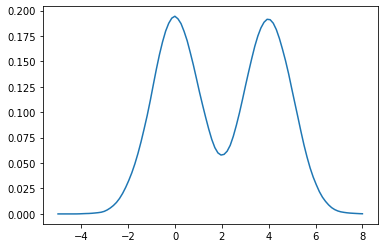

In [8]:
xs = np.linspace(-5,8,100)
density = kde(xs, x)
plt.plot(xs, density)
xlim = plt.xlim()
pass

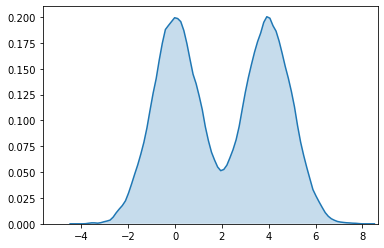

In [9]:
import seaborn as sns
sns.kdeplot(x, kernel='epa', bw='silverman', shade=True)
plt.xlim(xlim)
pass

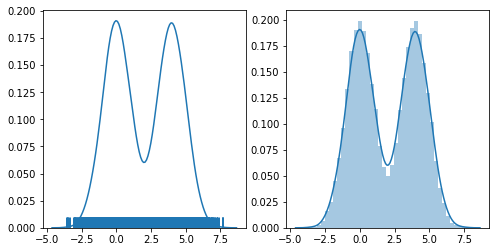

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
sns.distplot(x, hist=False, rug=True, ax=axes[0]);
sns.distplot(x, hist=True, ax=axes[1])
pass

There are several kernel density estimation routines available in scipy, statsmodels and scikit-learn. Here we will use the scikits-learn and statsmodels routine as examples.

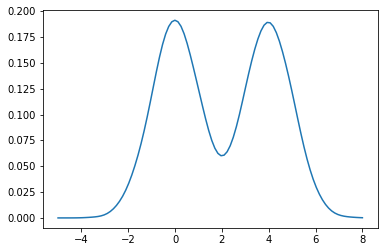

In [11]:
import statsmodels.api as sm

dens = sm.nonparametric.KDEUnivariate(x)
dens.fit(kernel='gau')
plt.plot(xs, dens.evaluate(xs))
pass

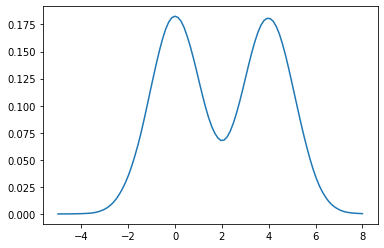

In [12]:
from sklearn.neighbors import KernelDensity

# expects n x p matrix with p features
x.shape = (len(x), 1)
xs.shape = (len(xs), 1)

kde = KernelDensity(kernel='epanechnikov').fit(x)
dens = np.exp(kde.score_samples(xs))
plt.plot(xs, dens)
pass

##The layered grammar of graphics

Hadley Wickham built ggplot2 (for R) based on a set of principles outlines in his layered grammar of graphics (inspired by Wilkinson’s orginal grammar of graphics). The basic idea is that a statistical graphic is a mapping from data to aesthetic attributes (such as colour, shape, and size) of geometric objects (such as points, lines, and bars).

We will use some of this terminology as we progess and discover that each piece of terminology corresponds to a type of object in ggplot2.

- data: a data frame containing the variables that you want to visualize

- geoms: geometric objects (circles, lines, text) that you will actually see

- aesthetics: the mapping from the data to the geographic objects (e.g. by describing position, size, colour, etc)



https://youtu.be/hVimVzgtD6w

In [14]:
import pandas as pd
from plotnine import *

# link to gapminder data as csv on the web 
csv_url='https://raw.githubusercontent.com/resbaz/r-novice-gapminder-files/master/data/gapminder-FiveYearData.csv'
# pandas read csv from URL
gapminder = pd.read_csv(csv_url)
gapminder.head()

,country,year,pop,continent,lifeExp,gdpPercap
0,Afghanistan,1952,8425333.0,Asia,28.801,779.445314
1,Afghanistan,1957,9240934.0,Asia,30.332,820.853030
2,Afghanistan,1962,10267083.0,Asia,31.997,853.100710
3,Afghanistan,1967,11537966.0,Asia,34.020,836.197138
4,Afghanistan,1972,13079460.0,Asia,36.088,739.981106


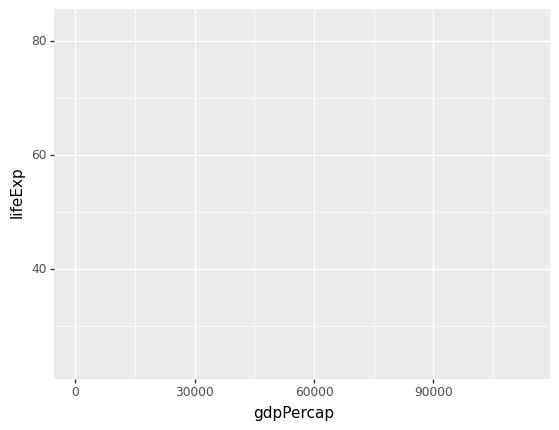

<ggplot: (8741640878961)>

In [15]:
ggplot(gapminder, aes(x='gdpPercap', y='lifeExp'))

In [16]:
import warnings
warnings.filterwarnings('ignore', module='plotnine')

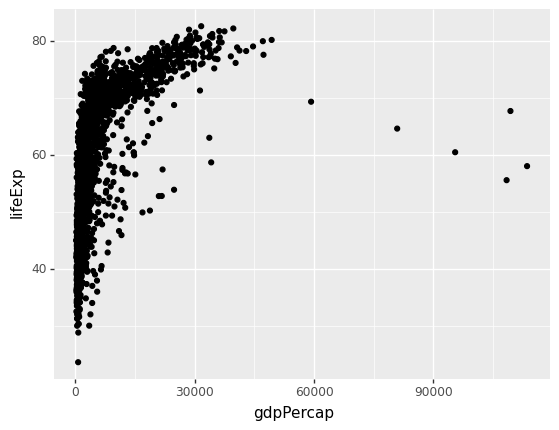

<ggplot: (-9223363295214706004)>

In [17]:
# describe the base ggplot object and tell it what data we are interested in along with the aesthetic mapping

# Note the need to wrap all the arguments in parentheses if you want to split your command onto multiple lines.
# Unlike in R, you can't end a line with a `+`

(ggplot(gapminder, aes(x='gdpPercap', y='lifeExp')) +
        geom_point()
)

### Aesthetic mapping to layers
What we have done is map each country (row) in the data to a point in the space defined by the GDP and life expectancy value. The end result is an ugly blob of points. Fortunately, there are many things that we can do to make this blob of points prettier.

For example, we can change the transparency of all points by setting the alpha argument to a low value, changing the color of the points to be blue instead of black, and making the points smaller.

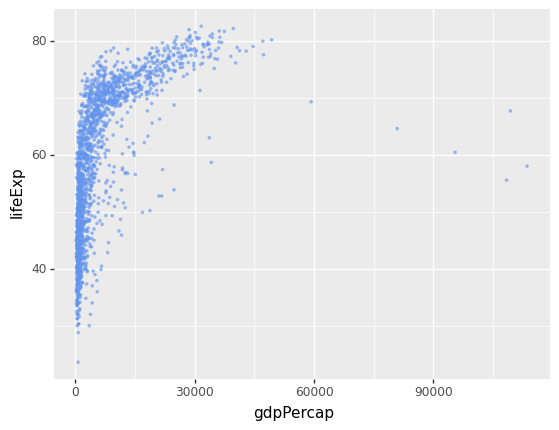

<ggplot: (-9223363295214750313)>

In [18]:
(ggplot(gapminder, aes(x='gdpPercap', y='lifeExp')) +
        geom_point(color='cornflowerblue', alpha = 0.5, size = 0.5)
)

Note that the above argument changed the alpha value and color for all of the points at once.

One of the truly powerful features of ggplot2 is the ability to change these aesthetics based on the data itself. For example, perhaps we want to color each point by its continent. Instead of separating the data into five different subsets (based on the possible values of continent), and adding the different colored points separately, we can simply add all the points once and add an colour aesthetic map for continent.

Note that whenever we are using a variable from the data to describe an aesthetic property of a geom, this aesthetic property needs to be included in the aes() function.

In [19]:
gapminder.continent.unique()

array(['Asia', 'Europe', 'Africa', 'Americas', 'Oceania'], dtype=object)

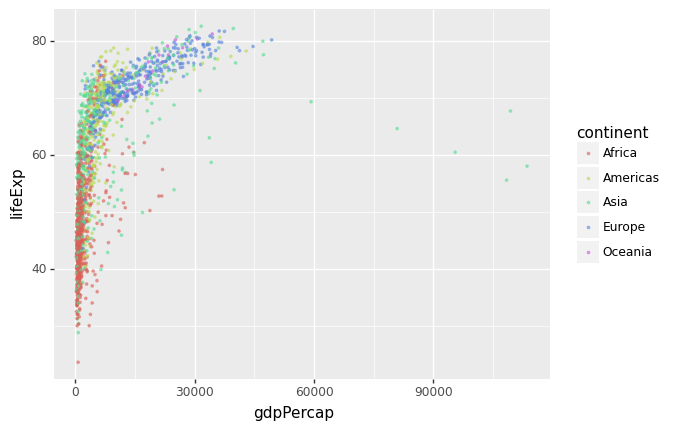

<ggplot: (-9223363295214724436)>

In [20]:
(ggplot(gapminder, aes(x='gdpPercap', y='lifeExp', color='continent')) +
        geom_point(alpha = 0.5, size = 0.5)
)

We could also add aesthetic mappings for other features such as shape, size, transparancy (alpha), and more! For example, changing the size based on population:

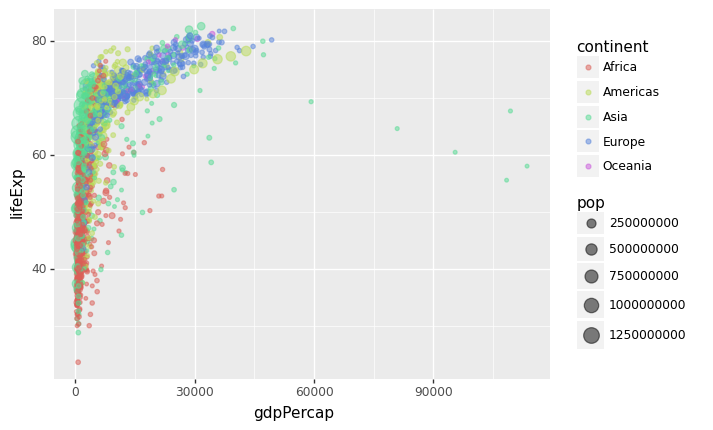

<ggplot: (-9223363295214996059)>

In [21]:
(ggplot(gapminder, aes(x='gdpPercap', y='lifeExp', color='continent', size='pop')) +
        geom_point(alpha = 0.5)
)

### Types of layers
So far, we have only seen scatterplots (point geoms), however, there are many other geoms we could add, including:

- lines

- histograms

- boxplots and violin plots

- barplots

- smoothed curves

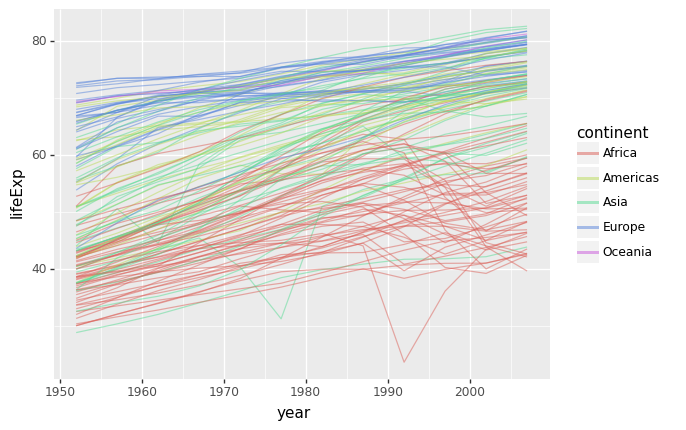

<ggplot: (8741638157141)>

In [22]:
(ggplot(gapminder, aes(x='year', y='lifeExp', group='country', color='continent')) +
        geom_line(alpha = 0.5)
)

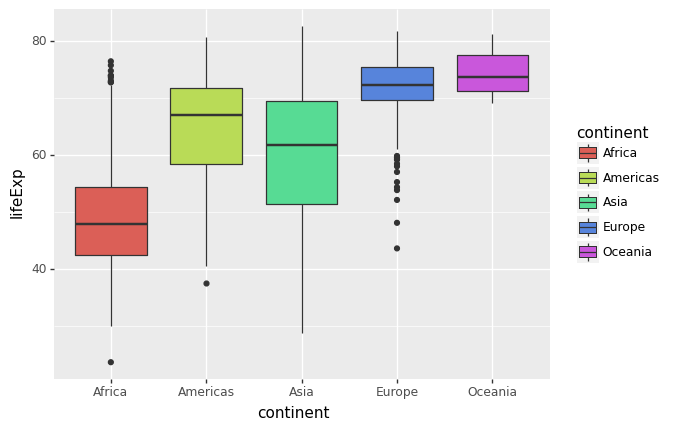

<ggplot: (-9223363295214945213)>

In [23]:
(ggplot(gapminder, aes(x='continent', y='lifeExp', fill='continent')) +
        geom_boxplot()
)

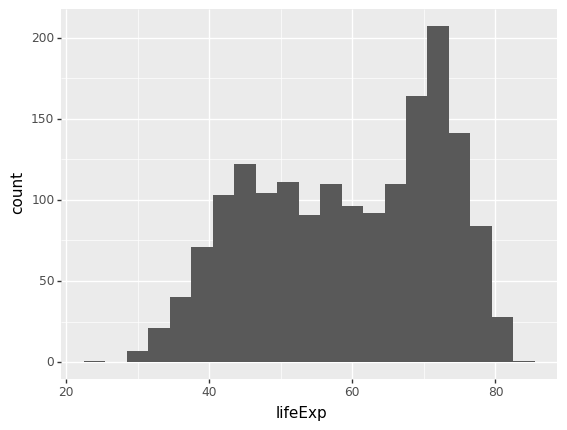

<ggplot: (-9223363295216654087)>

In [24]:
(ggplot(gapminder, aes(x='lifeExp')) +
        geom_histogram(binwidth = 3)
)

In [25]:
p = (ggplot(gapminder, aes(x='gdpPercap', y='lifeExp', size='pop')) +
        geom_point(aes(color='continent'), alpha = 0.5) #+
        #geom_smooth(se=False, method="loess", color="grey")
)
# save the plot
p.save("beautiful_plot_from_notebook.png")

In [27]:
!ls
#pip install scikit-misc

beautiful_plot_from_notebook.png  sample_data


OK, that’s a lot of different geometries. How are you supposed to remember all of them?

I suggested this this excellent cheatsheet: https://github.com/rstudio/cheatsheets/blob/master/data-visualization-2.1.pdf It was written for R, so there may be some very small syntactic differences from plotnine, but those differences are almost always very small.

# Resampling and Monte Carlo Simulations
Broadly, any simulation that relies on random sampling to obtain results fall into the category of Monte Carlo methods. Another common type of statistical experiment is the use of repeated sampling from a data set, including the bootstrap, jackknife and permutation resampling. Often, they are combined, as when we use a random set of permutations rather than the full set of permutations, which grows as O(n!) and is typically infeasible. What Monte Carlo simulations have in common is that they are typically more flexible but also more computationally demanding than methods based on asymptotic results. Because of their flexibility and the inexorable growth of computing power, I expect these computational simulation methods to only become more popular over time.

## Setting the random seed
In any probabilistic simulation, it is prudent to set the random number seed so that results can be replicated

In [28]:
np.random.seed(123)

### Sampling with and without replacement


In [29]:
# Sampling is done with replacement by default
np.random.choice(4, 12)

array([2, 1, 2, 2, 0, 2, 2, 1, 3, 2, 3, 1])

In [31]:
# Probability weights can be given
np.random.choice(4, 12, p=[.4, .1, .1, .4])

array([2, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0, 3])

In [32]:
x = np.random.randint(0, 10, (8, 12))
x

array([[5, 0, 2, 6, 2, 4, 4, 6, 3, 0, 6, 4],
       [7, 6, 7, 1, 5, 7, 9, 2, 4, 8, 1, 2],
       [1, 1, 3, 5, 9, 0, 8, 1, 6, 3, 3, 5],
       [9, 7, 9, 2, 3, 3, 3, 8, 6, 9, 7, 6],
       [3, 9, 6, 6, 6, 1, 3, 4, 3, 1, 0, 5],
       [8, 6, 8, 9, 1, 0, 3, 1, 3, 4, 7, 6],
       [1, 4, 3, 3, 7, 6, 8, 6, 4, 4, 7, 0],
       [0, 9, 8, 8, 4, 8, 6, 1, 6, 8, 7, 9]])

In [33]:
# sampling individual elements
np.random.choice(x.ravel(), 12)

array([6, 6, 6, 0, 3, 8, 3, 8, 9, 6, 7, 4])

In [34]:
# sampling rows
idx = np.random.choice(x.shape[0], 4)
x[idx, :]

array([[1, 4, 3, 3, 7, 6, 8, 6, 4, 4, 7, 0],
       [0, 9, 8, 8, 4, 8, 6, 1, 6, 8, 7, 9],
       [8, 6, 8, 9, 1, 0, 3, 1, 3, 4, 7, 6],
       [7, 6, 7, 1, 5, 7, 9, 2, 4, 8, 1, 2]])

In [35]:
# sampling columns
idx = np.random.choice(x.shape[1], 4)
x[:, idx]

array([[2, 4, 2, 2],
       [7, 7, 7, 7],
       [3, 0, 3, 3],
       [9, 3, 9, 9],
       [6, 1, 6, 6],
       [8, 0, 8, 8],
       [3, 6, 3, 3],
       [8, 8, 8, 8]])

### Sampling without replacement¶


In [36]:
# Give the argument replace=False
try:
    np.random.choice(4, 12, replace=False)
except ValueError as e:
    print(e)

Cannot take a larger sample than population when 'replace=False'


#### Random shuffling

In [37]:
x

array([[5, 0, 2, 6, 2, 4, 4, 6, 3, 0, 6, 4],
       [7, 6, 7, 1, 5, 7, 9, 2, 4, 8, 1, 2],
       [1, 1, 3, 5, 9, 0, 8, 1, 6, 3, 3, 5],
       [9, 7, 9, 2, 3, 3, 3, 8, 6, 9, 7, 6],
       [3, 9, 6, 6, 6, 1, 3, 4, 3, 1, 0, 5],
       [8, 6, 8, 9, 1, 0, 3, 1, 3, 4, 7, 6],
       [1, 4, 3, 3, 7, 6, 8, 6, 4, 4, 7, 0],
       [0, 9, 8, 8, 4, 8, 6, 1, 6, 8, 7, 9]])

In [38]:
# Shuffling occurs "in place" for efficiency
np.random.shuffle(x)
x

array([[0, 9, 8, 8, 4, 8, 6, 1, 6, 8, 7, 9],
       [5, 0, 2, 6, 2, 4, 4, 6, 3, 0, 6, 4],
       [3, 9, 6, 6, 6, 1, 3, 4, 3, 1, 0, 5],
       [1, 1, 3, 5, 9, 0, 8, 1, 6, 3, 3, 5],
       [9, 7, 9, 2, 3, 3, 3, 8, 6, 9, 7, 6],
       [7, 6, 7, 1, 5, 7, 9, 2, 4, 8, 1, 2],
       [8, 6, 8, 9, 1, 0, 3, 1, 3, 4, 7, 6],
       [1, 4, 3, 3, 7, 6, 8, 6, 4, 4, 7, 0]])

In [39]:
# To shuffle columns instead, transpose before shuffling
np.random.shuffle(x.T)
x

array([[8, 7, 6, 9, 0, 4, 8, 6, 8, 9, 8, 1],
       [4, 6, 4, 4, 5, 2, 2, 3, 6, 0, 0, 6],
       [1, 0, 3, 5, 3, 6, 6, 3, 6, 9, 1, 4],
       [0, 3, 8, 5, 1, 9, 3, 6, 5, 1, 3, 1],
       [3, 7, 3, 6, 9, 3, 9, 6, 2, 7, 9, 8],
       [7, 1, 9, 2, 7, 5, 7, 4, 1, 6, 8, 2],
       [0, 7, 3, 6, 8, 1, 8, 3, 9, 6, 4, 1],
       [6, 7, 8, 0, 1, 7, 3, 4, 3, 4, 4, 6]])

In [40]:
# numpy.random.permutation does the same thing but returns a copy
np.random.permutation(x)

array([[8, 7, 6, 9, 0, 4, 8, 6, 8, 9, 8, 1],
       [6, 7, 8, 0, 1, 7, 3, 4, 3, 4, 4, 6],
       [4, 6, 4, 4, 5, 2, 2, 3, 6, 0, 0, 6],
       [3, 7, 3, 6, 9, 3, 9, 6, 2, 7, 9, 8],
       [0, 3, 8, 5, 1, 9, 3, 6, 5, 1, 3, 1],
       [0, 7, 3, 6, 8, 1, 8, 3, 9, 6, 4, 1],
       [1, 0, 3, 5, 3, 6, 6, 3, 6, 9, 1, 4],
       [7, 1, 9, 2, 7, 5, 7, 4, 1, 6, 8, 2]])

In [ ]:
# When given an integer n, permutation treats is as the array arange(n)
np.random.permutation(10)

array([0, 5, 2, 4, 6, 8, 9, 1, 7, 3])

In [ ]:
# Use indices if you needed to shuffle collections of arrays in synchrony
x = np.arange(12).reshape(4,3)
y = x + 10
idx = np.random.permutation(x.shape[0])
list(zip(x[idx, :], y[idx, :]))

[(array([3, 4, 5]), array([13, 14, 15])),
 (array([0, 1, 2]), array([10, 11, 12])),
 (array([6, 7, 8]), array([16, 17, 18])),
 (array([ 9, 10, 11]), array([19, 20, 21]))]

## Bootstrap
The bootstrap is commonly used to estimate statistics when theory fails.

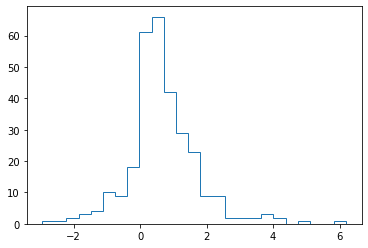

In [41]:
# For example, what is the 95% confidence interval for
# the 10th percentile of this data set if you didn't know how it was generated?

x = np.concatenate([np.random.exponential(size=200), np.random.normal(size=100)])
plt.hist(x, 25, histtype='step', linewidth=1)
pass

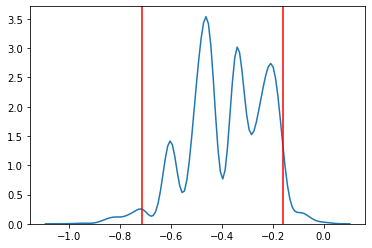

In [43]:
n = len(x)
reps = 10000
xb = np.random.choice(x, (n, reps))
mb = np.percentile(xb, 10, axis=0)
mb.sort()

lower, upper = np.percentile(mb, [2.5, 97.5])
sns.kdeplot(mb)
for v in (lower, upper):
    plt.axvline(v, color='red')

### Bootstrap example for Monte Carlo integration

In [44]:
def f(x):
    return x * np.cos(71*x) + np.sin(13*x)

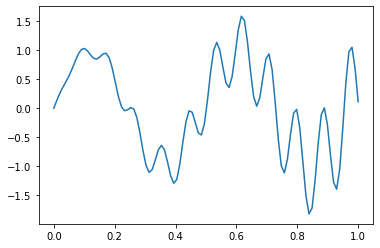

In [45]:
x = np.linspace(0, 1, 100)
plt.plot(x, f(x))
pass

In [46]:
# data sample for integration
n = 100
x = f(np.random.random(n))

In [47]:
# bootstrap MC integration
reps = 1000
xb = np.random.choice(x, (n, reps), replace=True)
yb = 1/np.arange(1, n+1)[:, None] * np.cumsum(xb, axis=0)
upper, lower = np.percentile(yb, [2.5, 97.5], axis=1)

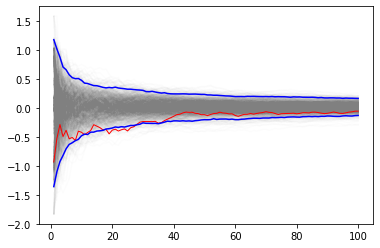

In [48]:
plt.plot(np.arange(1, n+1)[:, None], yb, c='grey', alpha=0.02)
plt.plot(np.arange(1, n+1), yb[:, 0], c='red', linewidth=1)
plt.plot(np.arange(1, n+1), upper, 'b', np.arange(1, n+1), lower, 'b')
pass

# Statistical inference:

Statistical inference helps the scientist to reach conclusions that extend beyond the obvious and immediate characterization of individual datasets. In some cases, the astronomer measures the properties of a limited sample of objects (often chosen to be brighter or closer than others) in order to learn about the properties of the vast underlying population of similar objects in the Universe. Inference is often based on a statistic, a function of random
variables.

Statistical inference is so pervasive throughout these astronomical and astrophysical
investigations that we are hardly aware of its ubiquitous role. It arises when the astronomer:
- smooths over discrete observations to understand the underlying continuous phenomenon
- seeks to quantify relationships between observed properties
- tests whether an observation agrees with an assumed astrophysical theory
- divides a sample into subsamples with distinct properties
- tries to compensate for flux limits and nondetections
- investigates the temporal behavior of variable sources
- infers the evolution of cosmic bodies from studies of objects at different stages
- characterizes and models patterns in wavelength, images or space

and many other situations.



Statistical inference helps in making judgments regarding the likelihood that a hypothesized effect in data arises by chance or represents a real effect. It is particularly designed to draw conclusions about the underlying population when the observed samples are subject to uncertainties.

The term statistical inference is very broad. Two main aspects of inference are estimation and the testing of hypotheses. Regression, goodness-of-fit, classification and many other statistical procedures fall under its framework. 

Statistical inference can be parametric, nonparametric and semi-parametric. Parametric inference requires that the scientist makes some assumptions regarding the mathematical structure of the underlying population, and
this structure has parameters to be estimated from the data at hand. Linear regression is an example of parametric inference. Nonparametric procedures make no assumption about the model structure or the distribution of the population. The Kolmogorov–Smirnov hypothesis test and the rank-based Kendall’s $\tau$ correlation coefficient are examples of nonparametric procedures.

## Point estimation:
 If the shape of the probability distribution, or relationship between
variables, of the underlying population is well-understood, then it remains to find the parameters of the distribution or relationship. For a dataset drawn from a Poisson distribution for example, we seek the value of the rate $\lambda$, while for a normal distribution, we want to estimate the mean $\mu$ and variance $\sigma$.


 Typically a probability distribution or relationship is characterized by a p-dimensional vector of model parameters $\theta = (\theta_{1}, \theta_{2}, . . . , \theta_{p})$. For example, the model of a planet in a Keplerian orbit around a star has a vector of six parameters: semi-major axis, eccentricity, inclination, ascending node longitude, argument of periastron and true anomaly.

 Analogous parameter lists can be made for a tidally truncated isothermal sphere of stars (King model), a turbulent viscous accretion disk (Shakura–Sunyaev disk model), the consensus model of cosmology with
dark matter and dark energy ( $\Lambda$CDM model), and many other well-developed astrophysical theories. The goal of estimating plausible or “best” values of $\theta$ based on observations is called **point estimation**.

In parametric point estimation, the astronomer must be very careful in setting up the statistical calculation. Two decisions must be made. First, the functional model and its parameters must be specified. If the model is not well-matched to the astronomical population or astrophysical process under study, then the best fit obtained by the inferential process may be meaningless. This problem is called **model misspecification**.
Statistical procedures are available to assist the scientist in model validation (or goodness-of-fit) and model selection. 

Second, the method by which best-fit parameters are estimated must be chosen. The method of moments, least squares (LS) and maximum likelihood estimation (MLE) are important and commonly used procedures for constructing estimates of the parameters. The choice of estimation method is not obvious, but can be guided by the scientific goal.

Statistical measures are available to assist the scientist in choosing a method: some may give best-fit parameters closest to the true value, with the greatest accuracy (smallest variance), or with the highest probability (maximum likelihood). Fortunately, for many situations we can find single best-fit parameter values that are simultaneously unbiased, have minimum
variance and have maximum likelihood.

In classical parametric estimation, the observations are assumed to be independently and identically distributed (i.i.d.) random variables with known probability distributions.

The dataset $x_{1} , x_{2}, . . . , x_{n}$ is assumed to be a realization of independent random variables $X_{1}, X_{2}, . . . ,X_{n}$ having a common probability distribution function (p.d.f.) $f$ . We
now consider distribution functions characterized by a small number of parameters, $\theta = (\theta_{1}, \theta_{2}, . . . , \theta_{p})$.

The **point estimator of the vector of true parameter values $\theta$** is
designated $\hat{θ}$ , pronounced “theta-hat”. The estimator $\hat{\theta}$ of $\theta$ is a function of the random variables ($X_{1}, X_{2}, . . . ,X_{n}$) under study,  $\hat{\theta}  = g(X_{1}, X_{2}, . . . ,X_{n})$.


The point estimator is thus a function of random variables of the underlying population that is computed from a realization of the population in a particular data sample.

A great deal of mathematics and discussion lies behind the simple goal of obtaining the “best” estimates of the parameters $\theta$ . One aspect relates to the method of obtaining estimators. 

- During the nineteenth century, the method of moments and method of least
squares were developed. Astronomy played a crucial role in least-squares theory. 

- As a young man in the 1910s and 1920s, R. A. Fisher formulated the
“likelihood” that a dataset fits a model, and inaugurated the powerful methods of maximum likelihood estimation (MLE). 

- Minimum variance unbiased estimators (MVUEs) later rose to prominence. As computers became more capable, numerically intensive methods with
fewer limitations than previous methods became feasible. The most important, developed in the 1970s and 1980s, is the bootstrap method. 

- With the advent of numerical methods like Markov chain Monte Carlo simulations, nontrivial Bayesian inferential computations
became feasible during the 1990s. 

- Bayesian computational methods are being actively
developed today.

Statisticians take into consideration several important criteria of
a point estimator:

- **Unbiasedness** The bias of an estimator $\hat{\theta}$ is defined to be the difference between the mean of estimated parameter and its true value: $B( \hat{\theta} ) = E[ \hat{\theta} ] − \theta$ .

This is not the error of a particular instantiation of $\hat{\theta}$ from a particular dataset. This is an intrinsic offset in the estimator.
An estimator $\hat{\theta}$ of a parameter $\theta$ is called unbiased if 
$B( \hat{theta} ) = 0$.

Heuristically, $\hat{\theta}$ is an unbiased if its long-term average value is equal to $\theta$ . If $\hat{\theta}$ is an unbiased estimator of $\theta$, then the variance of the estimator $\hat{\theta}$ is given by $ E[( \hat{\theta} − \theta )^{2}]$.

The smaller the variance of the estimator, the better the estimation procedure. However, In this case, if the estimator $\hat{\theta}$ is biased, then $E[( \hat{\theta} − \theta )^{2} ]$ is not the variance of $\theta$.


$$ E[( \hat{\theta} − \theta )^{2} ] = Var( \hat{\theta} ) + (E[ \hat{theta} − \theta ])^{2}$$

$$ MSE = Variance\ of| \hat{\theta} + (Bias)^{2} $$ .

This quantity, the sum of the variance and the square of the bias, is called the **mean square error (MSE)** and is very important in evaluating estimated parameters.

**Minimum variance unbiased estimator (MVUE)** Among a collection of unbiased estimators, the most desirable one has the smallest variance, $Var(\hat{\theta})$.

**Consistency** This criterion states that a **consistent estimator** will approach the true population parameter value as the sample size increases. More precisely, an estimator $\hat{\theta}$ for a parameter $\theta$ is weakly consistent if for any small $\epsilon > 0$, $P[| \hat{\theta} − \theta| ≥ \epsilon ] \rightarrow 0 $ as $n → \infty$. The estimator is **strongly consistent** if
$P[ \hat{\theta} \rightarrow \theta \ as \ n \ \rightarrow \infty] = 1$.

**Asymptotic normality** This criterion requires that an ensemble of consistent estimators $ \hat{\theta} (n)$ has a distribution around the true population value $\theta$ that approaches a normal (Gaussian) distribution with variance decreasing as $1/n$.

## Techniques of point estimation
Parameter estimation is motivated by the problem of fitting models from probability distributions or astrophysical theory to data. Many commonly used probability distributions (such as Gaussian, Poisson, Pareto or power-law) or astrophysical models (such as the temperature and pressure of a uniform gas, or masses and eccentricity in a planetary orbit) depend only on a few parameters.

Once these parameters are known, the shape and scale of the curve, and the corresponding properties of the underlying population, are completely determined.



## Method of moments
The method of moments for parameter estimation dates to the nineteenth century. 

The moments are quantitative measures of the parameters of a distribution: the first moment describes its central location; the second moment its width; and the third and higher moments describe asymmetries. The k-th moment of a
random variable X with distribution function F is given by:

$$\mu_{k} (X ) = E[X] = \int x^{k} dF (x)$$

For the random sample $X_{i}$ , the k-th sample moment is:

$$\hat{\mu}_{k}=\frac{1}{n}\sum_{i=1}^{n} X_{i}^k$$

Various parameters of a distribution can be estimated by the method of moments if one can first express the parameters as simple functions of the first few moments.

To illustrate some moment estimators, first consider the exponential distribution with p.d.f. $f (x) = \lambda exp(−\lambda x)$. The moment estimator for the rate $\lambda$ is $\hat{\lambda} = 1/ \bar{X}$  as $ E[X ] = 1/\lambda$. This result is not immediately obvious from a casual examination of the distribution.

Second, consider the normal distribution with the mean $\mu$ and variance $\sigma^2$ . The population moments and their sample estimators are:

$$\mu = E[X ]  \ and \ \hat{\mu}= \frac{1}{n} \sum_{i=1}^{n} X_{i}$$

$$ \sigma^{2} = E[X^{2}] − \mu^{2} \ and \ \hat{\sigma}^2=\frac{1}{n} \sum_{i=1}^{n} (X_{i}^{2} - \hat{\mu}^{2}) $$


Note that the variance is the central second moment. The moment-based variance estimator is not unbiased, as the unbiased variance has a factor $1/(n − 1)$ rather than $1/n$ before the summation.

## Method of least squares

Parameter estimation using least squares was developed in the early nineteenth century to solve problems in celestial mechanics, and has since been very widely used in astronomy and other fields.

Consider estimation of the population mean $\mu$. The least-squares estimator $\hat{\mu}$ is obtained by minimizing the sum of the squares of the differences $(X_{i} − \mu)$:

̂$$\hat{\mu}^{LS} = min_{\mu} \sum_{i=1}^{n} (X_{i}-\mu)^2$$

We can derive this as follows: 

$$ \sum_{i=1}^{n} (X_{i}-\mu)^2 = \sum_{i=1}^{n} (X_{i}- \bar{X})^2 + n(\bar{X}-\mu)^{2} + 2(\bar{X}-\mu) \sum_{i=1}^{n} (X_{i}-\bar{X})$$

In this simple case, μ̂ = X̄ which is the intuitive solution. But in more complex estimation
problems, particularly in the context of regression with a functional relationship between
two or more variables, this method provides solutions that are not intuitively obvious.


